# Clustering using Latent Dirichlet Allocation

In [1]:
%matplotlib inline

from gensim.models import Word2Vec
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from nltk.corpus import stopwords as sw
from nltk.stem.snowball import GermanStemmer
from gensim import corpora
from gensim.models import LdaModel
from sklearn import cluster
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
from sklearn.metrics.cluster import contingency_matrix
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


# there are quite a few long-running processes in this notebook.
# activated logging is a good way to get a status of these tasks
# disable logging for "presentation notebooks" since the logging uses stderr
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

stopwords = sw.words('german')
# gensims LineSentence generator replaces umlauts with 
# u, a or o so add these variants to the stopwordlist
for stopword in stopwords:
    stopword = stopword.replace(u'ü', 'u')
    stopword = stopword.replace(u'ö', 'o')
    stopword = stopword.replace(u'ä', 'a')
    if stopword not in stopwords:
        stopwords.append(stopword)
        
np.random.seed(0)

/Users/daniel/Library/Python/2.7/lib/python/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
category_names = ['Sonstiges', 'Aktuell', 'Lifestyle', 
          'Wirtschaft', 'Finanzen', 'Ausland', 'Lokal', 
          'Politik', 'Sport', 'Technologie', 'Kultur']

num_models = len(category_names)

# the list of full corpora
fulldata_paths = [(x, "corpus/corpus{}.txt".format(x)) for x in category_names]

# the corpora with a fixed split for training and validation
train_paths = [(x, "data/corpus{}.training.txt".format(x)) for x in category_names]
validation_paths = [(x, "data/corpus{}.validation.txt".format(x)) for x in category_names]

In [3]:
def load_sets(paths):
    log = logging.getLogger('load-sets')
    stemmer = GermanStemmer()
    X, y = [], []

    for name, path in paths:
        with open(path) as cur_file:
            log.info('now loading path {} ...'.format(path))
            
            #get the number of lines for logging and rewind the file to start
            lines = sum([1 for line in cur_file])
            cur_file.seek(0)
            
            for num, line in enumerate(cur_file):
                if num % 1000 == 0:
                    log.info('preprocessed {} of {} lines'.format(num, lines))
                tokens = [stemmer.stem(x.decode('utf-8')) for x in line.split() if x not in stopwords]
                if len(tokens) > 0:
                    X.append(tokens)
                    y.append(name)
    print("loaded {} articles".format(len(X)))
    return X, y

In [4]:
X, target = load_sets(fulldata_paths)

2017-01-27 18:09:46,997 : INFO : now loading path corpus/corpusSonstiges.txt ...
2017-01-27 18:09:47,017 : INFO : preprocessed 0 of 5005 lines
/Users/daniel/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:17: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
2017-01-27 18:10:01,766 : INFO : preprocessed 1000 of 5005 lines
2017-01-27 18:10:13,634 : INFO : preprocessed 2000 of 5005 lines
2017-01-27 18:10:24,713 : INFO : preprocessed 3000 of 5005 lines
2017-01-27 18:10:34,968 : INFO : preprocessed 4000 of 5005 lines
2017-01-27 18:10:45,230 : INFO : preprocessed 5000 of 5005 lines
2017-01-27 18:10:45,283 : INFO : now loading path corpus/corpusAktuell.txt ...
2017-01-27 18:10:45,284 : INFO : preprocessed 0 of 119 lines
2017-01-27 18:10:46,441 : INFO : now loading path corpus/corpusLifestyle.txt ...
2017-01-27 18:10:46,456 : INFO : preprocessed 0 of 2119 lines
2017-01-27 18:10:57,273 : INFO : preprocess

loaded 32200 articles


create a dictionary for the training data

In [5]:
dictionary = corpora.Dictionary(X)

2017-01-27 18:16:39,447 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-01-27 18:16:42,476 : INFO : adding document #10000 to Dictionary(126609 unique tokens: [u'toilettenpapi', u'baumring', u'fawk', u'abgesagt', u'bekleidungspaket']...)
2017-01-27 18:16:45,568 : INFO : adding document #20000 to Dictionary(167021 unique tokens: [u'toilettenpapi', u'baumring', u'fawk', u'abgesagt', u'parteiregeln']...)
2017-01-27 18:16:49,055 : INFO : adding document #30000 to Dictionary(204885 unique tokens: [u'toilettenpapi', u'\u201elangevin', u'familienunternehmennach', u'\u201ebloomberg\u201c', u'bekleidungspaket']...)
2017-01-27 18:16:50,630 : INFO : built Dictionary(224864 unique tokens: [u'toilettenpapi', u'\u201elangevin', u'familienunternehmennach', u'\u201ebloomberg\u201c', u'bekleidungspaket']...) from 32200 documents (total 8946251 corpus positions)


create a bag of words for every document

In [6]:
corpus = [dictionary.doc2bow(text) for text in X]

train the model

In [7]:
ldamodel = LdaModel(corpus, num_topics=num_models, id2word = dictionary, passes=20, random_state=0)

2017-01-27 18:16:59,951 : INFO : using symmetric alpha at 0.0909090909091
2017-01-27 18:16:59,952 : INFO : using symmetric eta at 0.0909090909091
2017-01-27 18:16:59,955 : INFO : using serial LDA version on this node
2017-01-27 18:17:11,485 : INFO : running online LDA training, 11 topics, 20 passes over the supplied corpus of 32200 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-01-27 18:17:11,491 : INFO : PROGRESS: pass 0, at document #2000/32200
2017-01-27 18:17:14,765 : INFO : merging changes from 2000 documents into a model of 32200 documents
2017-01-27 18:17:16,486 : INFO : topic #4 (0.091): 0.008*"dass" + 0.006*"mann" + 0.006*"jahr" + 0.005*"polizei" + 0.004*"mehr" + 0.004*"sagt" + 0.004*"sei" + 0.004*"jahrig" + 0.003*"deutsch" + 0.003*"mensch"
2017-01-27 18:17:16,499 : INFO : topic #5 (0.091): 0.007*"dass" + 0.006*"mann" + 0.005*"jahr" + 0.005*"mehr" + 0.005*"sagt" + 0.0

print the 5 most important words for each topic

In [8]:
ldamodel.print_topics(num_topics=11, num_words=5)

2017-01-27 18:39:32,246 : INFO : topic #0 (0.091): 0.026*"sz" + 0.019*"zeitung" + 0.017*"de" + 0.014*"anzeig" + 0.012*"mehr"
2017-01-27 18:39:32,260 : INFO : topic #1 (0.091): 0.010*"is" + 0.010*"mensch" + 0.008*"mehr" + 0.008*"polizei" + 0.007*"word"
2017-01-27 18:39:32,276 : INFO : topic #2 (0.091): 0.012*"jahr" + 0.010*"mehr" + 0.009*"prozent" + 0.007*"euro" + 0.007*"dass"
2017-01-27 18:39:32,290 : INFO : topic #3 (0.091): 0.016*"1" + 0.013*"spiel" + 0.008*"formel" + 0.007*"fc" + 0.007*"bay"
2017-01-27 18:39:32,303 : INFO : topic #4 (0.091): 0.023*"trump" + 0.015*"us" + 0.012*"prasident" + 0.008*"usa" + 0.008*"dass"
2017-01-27 18:39:32,318 : INFO : topic #5 (0.091): 0.014*"„deutschland" + 0.012*"prosieb" + 0.011*"berlin" + 0.010*"„promi" + 0.010*"wallraff"
2017-01-27 18:39:32,331 : INFO : topic #6 (0.091): 0.012*"dass" + 0.007*"schon" + 0.007*"jahr" + 0.005*"imm" + 0.005*"–"
2017-01-27 18:39:32,345 : INFO : topic #7 (0.091): 0.104*"tv" + 0.091*"kolumn" + 0.013*"–" + 0.009*"ard" + 0.

[(0,
  u'0.026*"sz" + 0.019*"zeitung" + 0.017*"de" + 0.014*"anzeig" + 0.012*"mehr"'),
 (1,
  u'0.010*"is" + 0.010*"mensch" + 0.008*"mehr" + 0.008*"polizei" + 0.007*"word"'),
 (2,
  u'0.012*"jahr" + 0.010*"mehr" + 0.009*"prozent" + 0.007*"euro" + 0.007*"dass"'),
 (3, u'0.016*"1" + 0.013*"spiel" + 0.008*"formel" + 0.007*"fc" + 0.007*"bay"'),
 (4,
  u'0.023*"trump" + 0.015*"us" + 0.012*"prasident" + 0.008*"usa" + 0.008*"dass"'),
 (5,
  u'0.014*"\u201edeutschland" + 0.012*"prosieb" + 0.011*"berlin" + 0.010*"\u201epromi" + 0.010*"wallraff"'),
 (6,
  u'0.012*"dass" + 0.007*"schon" + 0.007*"jahr" + 0.005*"imm" + 0.005*"\u2013"'),
 (7,
  u'0.104*"tv" + 0.091*"kolumn" + 0.013*"\u2013" + 0.009*"ard" + 0.007*"zdf"'),
 (8,
  u'0.018*"merkel" + 0.015*"\u201ehart" + 0.013*"polit" + 0.012*"deutschland" + 0.011*"fluchtling"'),
 (9,
  u'0.008*"nutz" + 0.008*"neu" + 0.005*"smartphon" + 0.005*"gerat" + 0.004*"will\u201c"'),
 (10,
  u'0.025*"\xbb" + 0.016*"fehl" + 0.014*"artikel" + 0.014*"kauf" + 0.013*"f

## visualize the clusters using the topics transformed using TSNE

In [9]:
article_topics = [ldamodel[doc] for doc in corpus]

Transform the corpus to a form the TSNE can understand.

The Data from the LDA is a list of tuples in the form ```(topic, proportion)```. The TSNE needs the data as an ordered list of topics.

In [10]:
def topics_to_matrix(topics):
    matrix = np.zeros([len(topics), num_models])
    for i, article in enumerate(topics):
        for topic, proportion in article:
            matrix[i, topic] = proportion
    return matrix

topic_matrix = topics_to_matrix(article_topics)

In [11]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(topic_matrix)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


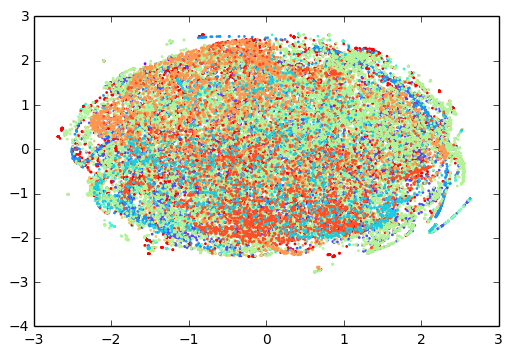

In [12]:
#convert the categories to ints
category_ints, int_target = np.unique(target, return_inverse=True)
colorspace = cm.rainbow(np.linspace(0, 1, len(category_ints)))

colors = [colorspace[y] for y in int_target]
for x, y, color in zip(X_tsne[:, 0], X_tsne[:, 1], colors):
    plt.scatter(x, y, color=color, s=1);

plt.show()

# calculate cluster performance

In [13]:
def print_cluster_performance(name, predicted):
    print('{}:'.format(name))
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(int_target, predicted)
    print('\thomogenity:\t{}'.format(homogeneity))
    print('\tcompleteness:\t{}'.format(completeness))
    print('\tv-measure:\t{}'.format(v_measure))
    print('')

In [16]:
clustering_names = [
    'MiniBatchKMeans', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']
n_clusters = len(category_names)

# normalize dataset for easier parameter selection
topic_matrix = StandardScaler().fit_transform(topic_matrix)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(topic_matrix, quantile=0.3)

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(topic_matrix, n_neighbors=10, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# create clustering estimators
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                       connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=.2)
affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                   preference=-200)

average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock", n_clusters=n_clusters,
    connectivity=connectivity)

birch = cluster.Birch(n_clusters=n_clusters)
clustering_algorithms = [
    two_means, ms, spectral, ward, average_linkage,
    dbscan, birch]

In [17]:
for name, algorithm in zip(clustering_names, clustering_algorithms):
    %time predicted = algorithm.fit_predict(topic_matrix)
    print_cluster_performance(name, predicted)

CPU times: user 160 ms, sys: 34.2 ms, total: 194 ms
Wall time: 240 ms
MiniBatchKMeans:
	homogenity:	0.275950239961
	completeness:	0.261463362737
	v-measure:	0.268511542417

CPU times: user 2.57 s, sys: 132 ms, total: 2.7 s
Wall time: 2.74 s
MeanShift:
	homogenity:	0.00136038706496
	completeness:	0.0881346536946
	v-measure:	0.00267941646472



/Library/Python/2.7/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


CPU times: user 16min 8s, sys: 22.5 s, total: 16min 30s
Wall time: 14min 46s
SpectralClustering:
	homogenity:	0.0251272597677
	completeness:	0.19408192357
	v-measure:	0.0444940018981



/Library/Python/2.7/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


CPU times: user 5.71 s, sys: 364 ms, total: 6.07 s
Wall time: 6.32 s
Ward:
	homogenity:	0.266374525672
	completeness:	0.252627088263
	v-measure:	0.259318734282



/Library/Python/2.7/site-packages/sklearn/cluster/hierarchical.py:418: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


CPU times: user 2min 48s, sys: 3.59 s, total: 2min 52s
Wall time: 2min 51s
AgglomerativeClustering:
	homogenity:	0.0228165385309
	completeness:	0.198671133318
	v-measure:	0.0409321885096

CPU times: user 5.03 s, sys: 34.6 ms, total: 5.06 s
Wall time: 5.06 s
DBSCAN:
	homogenity:	0.114639442366
	completeness:	0.204090317228
	v-measure:	0.14681277449

CPU times: user 3.47 s, sys: 646 ms, total: 4.12 s
Wall time: 3.48 s
Birch:
	homogenity:	0.242425781726
	completeness:	0.226253169985
	v-measure:	0.234060443301

